# Testing One-Point GEV Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pycic.distributions as dist

## Cosmology Object

In [2]:
c = dist.Cosmology(Om0 = 0.3, Ob0 = 0.05, h = 0.7, ns = 1, sigma8 = 0.8)
print(c)

Cosmology(Om0=0.3, Ob0=0.05, Ode0=0.7, Onu0=0, h=0.7, Tcmb0=2.725K, ns=1, sigma8=0.8)


In [3]:
def drawCosmologyFunction(c: dist.Cosmology, z: np.ndarray):
    """ draw cosmology functions. """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6), )

    ax1.plot(z, c.Omz(z), label = 'matter')
    ax1.plot(z, c.Odez(z), label = 'dark-energy')
    ax1.set(xlabel = 'z', ylabel = '$\\Omega_i$(z)')
    ax1.legend(
                    bbox_to_anchor = (0., 1.02, 1., 0.102), 
                    loc  = 'lower left',
                    ncol = 2, mode = 'expand', borderaxespad = 0,
               )

    ax2.plot(z, c.Dz(z), label = 'growth factor, D(z)')
    ax2.plot(z, c.fz(z), label = 'growth rate, f(z)')
    ax2.set(xlabel = 'z', ylabel = 'D(z) or f(z)')
    ax2.legend(
                    bbox_to_anchor = (0., 1.02, 1., 0.102), 
                    loc  = 'lower left',
                    ncol = 2, mode = 'expand', borderaxespad = 0,
               )
    
    plt.show()

def drawPowerVariance(c: dist.Cosmology, k: np.ndarray, r: np.ndarray, z: np.ndarray):
    """ draw the power spectrum and variance. """
    # create a colormap
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(z.min(), z.max()),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), gridspec_kw = {"width_ratios": [1, 1, 0.05]}, )
    ax1.loglog(); ax2.loglog()

    for zi in z:
        ax1.plot(k, c.matterPowerSpectrum(k, zi), '-', color = cmap.to_rgba(zi), )
        ax2.plot(k, c.variance(r, zi), '-', color = cmap.to_rgba(zi), )

    ax1.set(xlabel = 'k', ylabel = 'P(k)')
    ax2.set(xlabel = 'r', ylabel = '$\\sigma^2$(r)')

    plt.colorbar(cmap, cax = cax, orientation = 'vertical')
    cax.set(ylabel = 'redshift')

    plt.show()

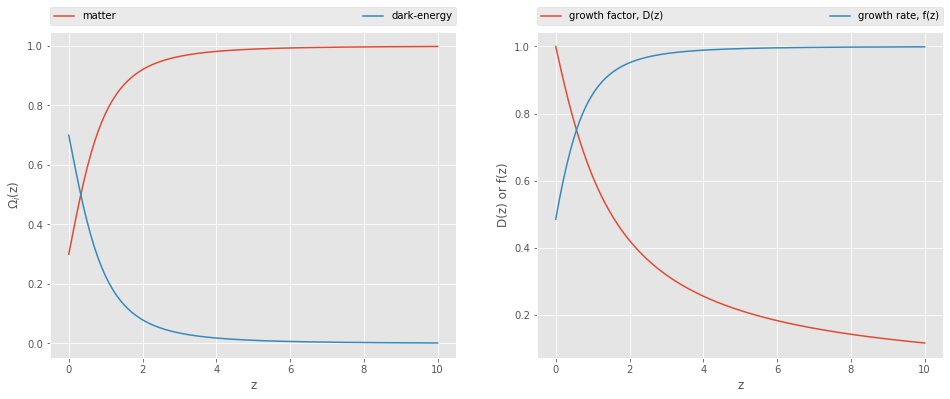

In [5]:
# draw densities and linear growth factors:
drawCosmologyFunction(c, z = np.mgrid[0:10:201j],)

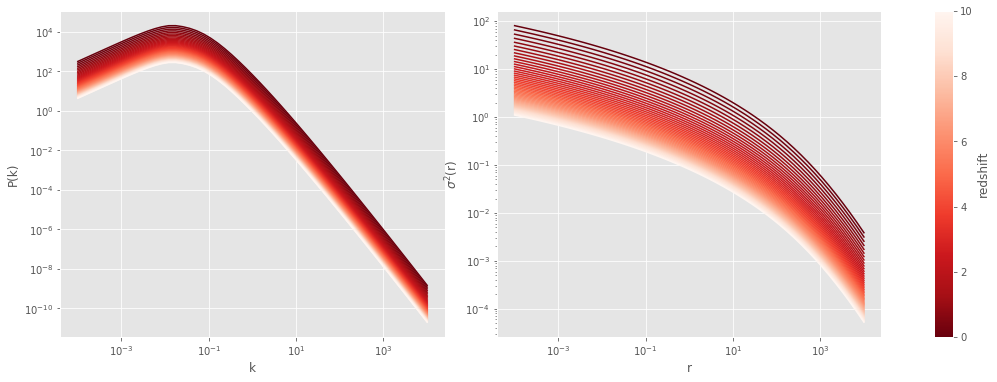

sigma^2(8 Mpc/h) =  0.6400000000000001


In [6]:
# draw normalised power spectrum and variances:
drawPowerVariance(c, k = np.logspace(-4, 4, 51), r = np.logspace(-2, 2, 51), z = np.mgrid[0:10:51j],)

print("sigma^2(8 Mpc/h) = ", c.variance(8))

## One-Point GEV Distribution

In [4]:
# distribution at redshift 0
d = dist.GEVDistribution(1.95, c, 0)

### Variances

In [5]:
vlin = d.linearCellVariance()
vlog = d.logCellVariance(vlin)

print("linear cell variance    =", vlin)
print("log-field cell variance =", vlog)
print("log-field bias          =", np.sqrt(vlog / vlin))

linear cell variance    = 5.401189201640844
log-field cell variance = 1.5535126152738423
log-field bias          = 0.5363060507056775


### Measured Power Spectrum and CIC Variance

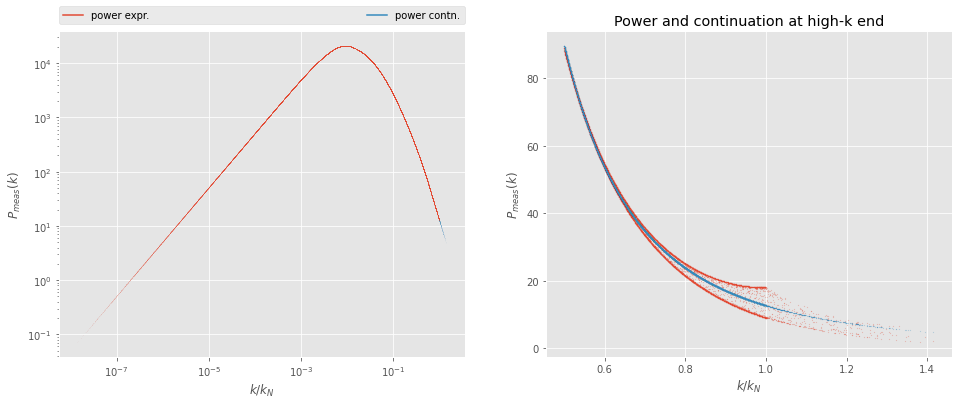

In [7]:
def drawMeasuredPower(d: dist.GEVDistribution, n: int):
    """ draw the measured power as function of k """
    # generate some random k vectors inside the cube:
    logkn      = np.log10(d.kn)
    kx, ky, kz = 10**np.random.uniform(-8, logkn, (3, n)) * np.random.choice([-1, 1], (3, n))

    k = np.sqrt(kx**2 + ky**2 + kz**2)

    pk     = d.measuredPowerSpectrum(kx, ky, kz)
    pk_in  = d._measuredPowerInsideSphere(kx, ky, kz) * d.cosmo._pknorm
    pk_out = d._measuredPowerOutsideSphere(k) * d.cosmo._pknorm

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

    ax1.loglog()

    mask = (k <= d.kn)
    ax1.plot([], [], '-', color = 'C0', label = 'power expr.')
    ax1.plot([], [], '-', color = 'C1', label = 'power contn.')
    ax1.plot(k[ mask]/d.kn, pk[mask], 'o', ms = 0.01, color = 'C0')
    ax1.plot(k[~mask]/d.kn, pk[~mask], 'o', ms = 0.01, color = 'C1')
    ax1.set(xlabel = '$k/k_N$', ylabel = '$P_{meas}(k)$')
    ax1.legend(
                bbox_to_anchor =(0., 1.02, 1., 0.102), 
                loc  = 'lower left',
                ncol = 2, mode = 'expand', borderaxespad = 0, 
              )

    # draw the large k end:
    mask = (k > d.kn * 0.5)
    ax2.plot(k[mask]/d.kn, pk_in [mask], 'o', ms = 0.1, color = 'C0', ) 
    ax2.plot(k[mask]/d.kn, pk_out[mask], 'o', ms = 0.1, color = 'C1', ) 
    ax2.set(xlabel = '$k/k_N$', ylabel = '$P_{meas}(k)$')
    ax2.set_title("Power and continuation at high-k end")

    plt.show()

drawMeasuredPower(d, 100_000)

In [8]:
vcic = d.measuredVariance() * vlog / vlin
print("measured cic varaince = ", vcic)

measured cic varaince =  1.4083522688613452


### Distribution Function for Log-Field

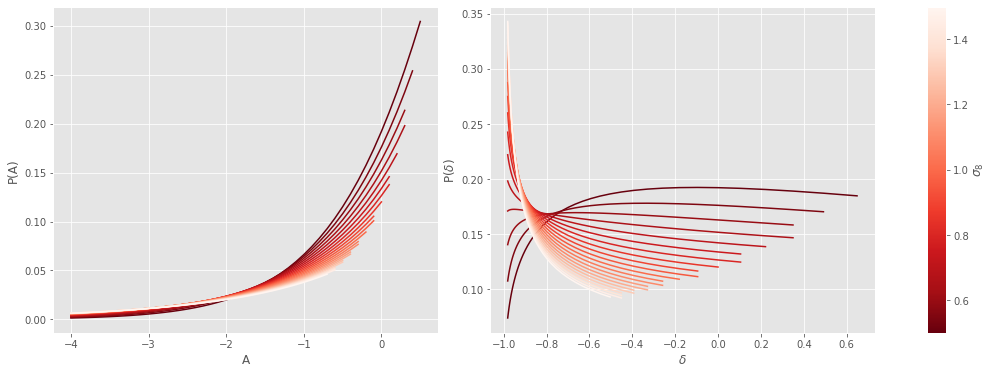

In [11]:
def drawDistributionFunction(d: dist.GEVDistribution, a: np.ndarray, s8: np.ndarray):
    """ draw the distribution function as function of sigma8 """
    from matplotlib import colors, cm 
    cmap = cm.ScalarMappable(
                                norm = colors.Normalize(s8.min(), s8.max()),
                                cmap = cm.Reds_r
                            )
    cmap.set_array([])

    delta = np.exp(a)-1 # delta

    fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (16, 6), gridspec_kw = {"width_ratios": [1, 1, 0.05]}, )

    for sigma8 in s8:
        d.parametrize(sigma8, ) # parametrise the pdf
        fa = d.pdf_log(a)       # a is ln(1+delta)
        fd = d.pdf(delta)

        mask = (fa > 0.0)
        ax1.plot(a[mask], fa[mask], '-', color = cmap.to_rgba(sigma8), )
        ax2.plot(delta[mask], fd[mask], '-', color = cmap.to_rgba(sigma8), )

    ax1.set(xlabel = 'A', ylabel = 'P(A)')
    ax2.set(xlabel = '$\\delta$', ylabel = 'P($\\delta$)')

    plt.colorbar(cmap, cax = cax, orientation = 'vertical')
    cax.set(ylabel = '$\\sigma_8$')

    plt.plot()

drawDistributionFunction(d, a = np.mgrid[-4:1:51j], s8 = np.mgrid[0.5:1.5:21j])